In [1]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch
import numpy as np
import scipy.misc
import imageio
from PIL import Image
import glob
# from data_preprocess import DiskImageDataset
import time

class shiftData(object):
    def __call__(self, img):
        is_numpy = type(img) is np.ndarray
        
        h, w = img.shape[:2] if is_numpy else img.shape[1:]
        x = np.array(range(h))
        y = np.array(range(w))

        xv, yv = np.meshgrid(x, y, sparse=False, indexing='ij')

        xv_flat = np.asarray(xv.flat)
        yv_flat = np.asarray(yv.flat)
        index = np.full_like(xv_flat, -1)**(xv_flat + yv_flat)
        
        index = index.reshape((h, w, -1)) if is_numpy else index.reshape((-1, h, w))
        
        return (img*index) if is_numpy else (img*index).float()

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)), shiftData()])

# use_cuda = torch.cuda.is_available()
# for num_workers in range(10, 50, 5):  # 遍历worker数
#     kwargs = {'num_workers': num_workers, 'pin_memory': False} if use_cuda else {}
#     size = 128
    
#     dataset = DiskImageDataset(glob.glob('data/lsun/church_outdoor' + str(size) + '/*.png'), map_fn=transform)
#     data_loader = DataLoader(dataset, batch_size=64, shuffle=True, **kwargs)

#     start = time.time()
#     # for epoch in range(1, 3):
#     for batch_idx, (data) in enumerate(data_loader): # 不断load
#         print(data.shape)
#         if batch_idx == 1:
#             break
#     # end = time.time()
#     # print("Finish with:{} second, num_workers={}".format(end-start, num_workers))


class DiskImageDataset():

    def __init__(self, img_paths, labels=None, map_fn=None):
        # nest data
        self.img_paths = img_paths
        self.labels = labels
        self.map_fn = map_fn
        
    def pil_loader(self, path):
        with open(path, 'rb') as f:
            return Image.open(f).convert('RGB')
        
    def __getitem__(self, i):
        if self.map_fn is not None:
            return self.map_fn(self.pil_loader(self.img_paths[i]))
        else:
            return self.pil_loader(self.img_paths[i])
    
    def __len__(self):
        return len(self.img_paths)

dataset = DiskImageDataset(glob.glob('data/lsun/church_outdoor' + str(32) + '/*.png'), map_fn=None)
# data_loader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=10)

for batch_idx, (data) in enumerate(dataset): # 不断load
    print(np.asarray(data).shape)
    if batch_idx == 1:
        break

(32, 32, 3)
(32, 32, 3)


7621


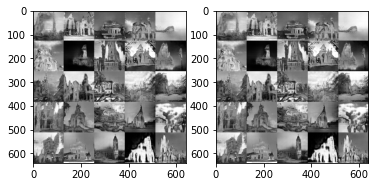

In [12]:
import cv2
import matplotlib.pyplot as plt

p = '/data0/cly/spectralGan/GAN-collections/results/shift/lsun-church_outdoor/WGAN_GP_128_100/WGAN_GP_128_100_epoch035.png'
img1 = cv2.imread(p, 0)
img2 = Image.open(p).convert('RGB')
img2_gray = np.asarray(img2).dot([0.2989, 0.5870, 0.1140])

plt.subplot(121)
plt.imshow(img1, 'gray')
plt.subplot(122)
plt.imshow(img2_gray, 'gray')

print(np.sum(np.abs(np.uint8(img1)-np.uint8(img2_gray))))

In [68]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import radialProfile
import glob
import cv2
from scipy.interpolate import griddata
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import glob

folder = '/data0/cly/spectralGan/GAN-collections/data/celeba/celeba64/*.png'
number_iter = 4800
spectrum_mat = np.zeros([number_iter, 64*64])
cont = 0
spectrum_f = np.zeros([64, 64], dtype='float64')

for filename in glob.glob(folder):
    
    img = cv2.imread(filename, 0)
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    fshift += 1e-8

    magnitude_spectrum = 20*np.log(np.abs(fshift))
    spectrum_f += magnitude_spectrum

    spectrum_mat[cont,:] = magnitude_spectrum.flatten()
    # Calculate the azimuthally averaged 1D power spectrum
    # psd1D = radialProfile.azimuthalAverage(magnitude_spectrum)
    # psd1D = (psd1D-np.min(psd1D))/(np.max(psd1D)-np.min(psd1D))
    # psd1D_total[cont,:] = psd1D  

    cont+=1
    
    if cont == number_iter:
        break

# for x in range(self.N):
#     psd1D_org_mean[x] = np.mean(psd1D_total[:,x])
#     psd1D_org_std[x] = np.std(psd1D_total[:,x])

(4800, 4096)


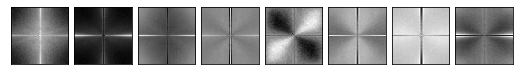

In [69]:
import numpy as np
from sklearn.decomposition import PCA
spectrum_mat -= np.mean(spectrum_mat) 
spectrum_mat /= np.std(spectrum_mat) 

pca = PCA(n_components=8, svd_solver='auto')
pca.fit(spectrum_mat)

# print(pca.explained_variance_ratio_)

# print(pca.singular_values_)

# print(pca.inverse_transform())
# print(nexX.shape)
print(spectrum_mat.shape)

fig, axes = plt.subplots(1, 8, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(pca.components_[i].reshape(64, 64), cmap='gray')

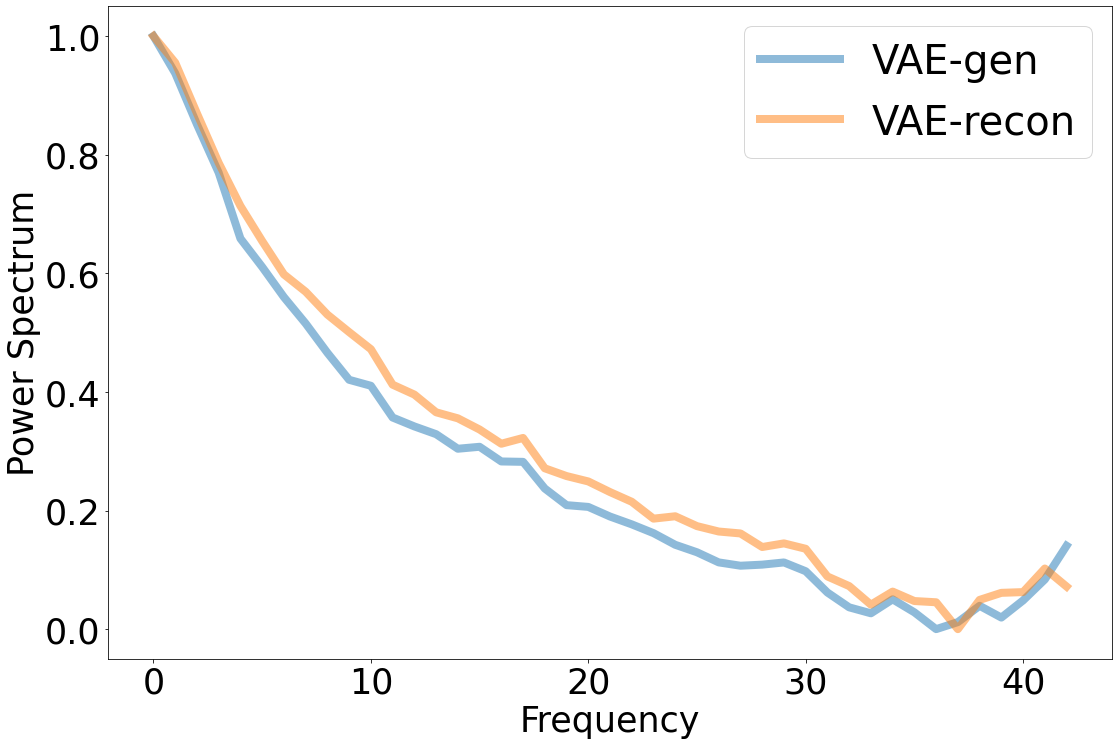

In [73]:
def single_psd(filename):
    img = cv2.imread(filename, 0)
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    fshift += 1e-8

    magnitude_spectrum = 20*np.log(np.abs(fshift))

    # Calculate the azimuthally averaged 1D power spectrum
    psd1D = radialProfile.azimuthalAverage(magnitude_spectrum)
    psd1D = (psd1D-np.min(psd1D))/(np.max(psd1D)-np.min(psd1D))

    return psd1D

vae_gen = single_psd('/data0/cly/spectralGan/VAE/gen.png')
vae_recon = single_psd('/data0/cly/spectralGan/VAE/recon.png')

x = np.arange(0, 43, 1)
fig, ax = plt.subplots(figsize=(20, 14))

ax.plot(x, vae_gen, alpha=0.5, label='VAE-gen', linewidth=8.0)
ax.plot(x, vae_recon, alpha=0.5, label='VAE-recon', linewidth=8.0)

plt.xlabel('Frequency', fontsize=35)
plt.ylabel('Power Spectrum', fontsize=35)
plt.tick_params(axis='x', labelsize=35)
plt.tick_params(axis='y', labelsize=35)

ax.legend(loc='best', prop={'size': 35})

In [5]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import radialProfile
import glob
import cv2
from scipy.interpolate import griddata
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import glob

import scipy.misc

ct_dataset = '/data0/cly/spectralGan/GAN-collections/data/CT_COVID/CT_COVID/*.png'
ct128_folder = '/data0/cly/spectralGan/GAN-collections/data/CT_COVID/CT_COVID128/'

vhr_dataset = '/data0/cly/spectralGan/GAN-collections/data/VHR10/VHR10/positive/*.jpg'
vhr256_folder= '/data0/cly/spectralGan/GAN-collections/data/VHR10/VHR10256/'

xray_dataset = '/data0/cly/spectralGan/GAN-collections/data/chest_xray/chest_xray128/*.png'
xray_folder = '/data0/cly/spectralGan/GAN-collections/data/chest_xray/chest_xray64/'

dota_dataset = '/data0/cly/spectralGan/GAN-collections/data/DOTA/images3/images/*.png'
dota_folder = '/data0/cly/spectralGan/GAN-collections/data/DOTA/DOTA256/'

maps_dataset = '/data0/cly/spectralGan/GAN-collections/data/maps/maps256_outline/*.png'
maps_folder = '/data0/cly/spectralGan/GAN-collections/data/maps/maps64/'
maps_folder_outline = '/data0/cly/spectralGan/GAN-collections/data/maps/maps64_outline/'

#1096
cont = 0
for filename in glob.glob(maps_dataset):

    img = cv2.imread(filename)

    img = cv2.resize(img, (64, 64))

    cv2.imwrite(maps_folder_outline + str("%05d" % cont) + '.png', img)
   
    cont += 1




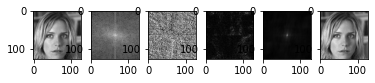

In [67]:
import matplotlib.pyplot as plt
import matplotlib.image
import numpy as np
import scipy.misc
import shutil
import radialProfile
import glob
import cv2
from scipy.interpolate import griddata
import numpy as np
from PIL import Image
import glob

img = 'data/celeba/celeba128/celeba128_109.png'

x_ = cv2.imread(img, 0)
f = np.fft.fft2(x_)
fshift = np.fft.fftshift(f)
fshift += 1e-8

magnitude_spectrum = np.abs(fshift)
phase_spectrum = np.angle(fshift)

img_rec1 = np.fft.ifft2(np.multiply(1, np.exp(1j*phase_spectrum)))
img_rec2 = np.fft.ifftshift(np.fft.ifft2(np.multiply(magnitude_spectrum, 1)))
img_rec3 = np.fft.ifft2(np.multiply(magnitude_spectrum, np.exp(1j*phase_spectrum)))

plt.subplot(1,6,1)
plt.imshow(x_, cmap = 'gray')
plt.subplot(1,6,2)
plt.imshow(np.log(magnitude_spectrum), cmap = 'gray')
plt.subplot(1,6,3)
plt.imshow(phase_spectrum, cmap = 'gray')
plt.subplot(1,6,4)
plt.imshow(np.abs(img_rec1), cmap = 'gray')
plt.subplot(1,6,5)
plt.imshow(np.abs(img_rec2), cmap = 'gray')
plt.subplot(1,6,6)
plt.imshow(np.abs(img_rec3), cmap = 'gray')

scipy.misc.imsave('magnitude_spectrum.png', np.array(np.log(magnitude_spectrum)))
scipy.misc.imsave('phase_spectrum.png', np.array(phase_spectrum))
scipy.misc.imsave('rec1.png', np.array(np.abs(img_rec1)))
scipy.misc.imsave('rec2.png', np.array(np.abs(img_rec2)))

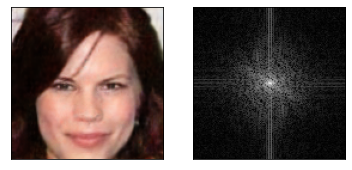

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image
import numpy as np
import scipy.misc

import warnings
warnings.filterwarnings("ignore")
from PIL import Image

img = './celeba_DRAGAN_SR_128_50_inverse_rec.png'

x_0 = matplotlib.image.imread(img)
x = np.array(x_0)
x = 0.299 * x[:, :, 0] + 0.587 * x[:, :, 1] + 0.114 * x[:, :, 2]
x = np.fft.fft2(x).real
x = np.fft.fftshift(x)
x = np.log(1 + np.abs(x))

plt.subplot(1,2,1)
plt.xticks([])  
plt.yticks([])
plt.imshow(x_0, cmap = 'gray')
plt.subplot(1,2,2)
plt.xticks([])
plt.yticks([])
plt.imshow(x, cmap = 'gray')
scipy.misc.imsave(img + '_Spectrum.png', x)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


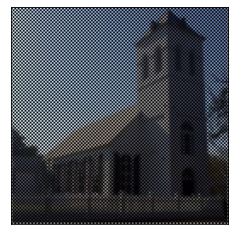

In [33]:
import matplotlib.pyplot as plt
import matplotlib.image
import numpy as np
import scipy.misc

import warnings
warnings.filterwarnings("ignore")
from PIL import Image

img = './church_outdoor128_449.png_Spectrum.png'
x = matplotlib.image.imread(img)
x = np.array(x)
# x = 0.299 * x[:, :, 0] + 0.587 * x[:, :, 1] + 0.114 * x[:, :, 2]

for i in range(128):
    for j in range(128):
        if  (i+j)%2==1 :
             x[i, j, :] = -x[i, j, :]


plt.xticks([])  
plt.yticks([])
plt.imshow(x)

scipy.misc.imsave(img + '_Spectrum.png', x)
